#### Make Figure 7

Opportunity Cost model - and also related supplemental figures

Set working folder (replace with path to this folder)

In [1]:
working_folder = '/Users/erussek/Dropbox/Griffiths_Lab_Stuff/Code/Thinking_Time_VOC_Chess'

Load Packages


In [2]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import time
import sys
import time
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import filters
from scipy.interpolate import interp1d
import matplotlib.cm as cm

plt.rcParams['svg.fonttype'] = 'none'


Load info for each time-control setting, what max time was in it, what increment was and all job indices (from compute win-rate step which separated in parallel by month)

In [3]:
these_tcs = ['60+0', '120+1', '180+0',
                '180+2', '300+0', '300+3',
                '600+0', '600+5', '900+10',
                '1800+0', '1800+20']

these_maxts = np.array([60,120,180,
               180,300,300,
               600,600,900,
               1800,1800])

these_time_back = [0, 1, 0, 
                  2, 0, 3,
                  0, 5, 10,
                  0, 20]

job_idxs = range(11)

Compute aggregate win-rates per current win probability (U), time-left (T), and time-control setting (TC) - aggregating accross each month, which was computed separately

In [4]:
saved_folder = os.path.join(working_folder, "Cost_of_Time_Analysis", "Saved_Quantities", "aggregate_win_rates")

res_dfs=[]
i = 0
for i in range(len(these_tcs)):
    for job_idx in job_idxs:
        file_name = 'emp_val_{}_{}'.format(these_tcs[i],job_idx)
        res_df = pd.read_csv(os.path.join(saved_folder, file_name), index_col=0)
        res_df['time_condition']=these_tcs[i]
        res_df['job_idx']=job_idx
        res_dfs.append(res_df)
        
full_res_df = pd.concat(res_dfs, ignore_index=True)
agg_df = full_res_df.groupby(['time_condition', 'wp_bin', 'tl_bin']).agg({'active_wonsum': 'sum', 'active_woncount': 'sum'}).reset_index()
agg_df['prop_win']= agg_df['active_wonsum']/agg_df['active_woncount']

# set missing values to .5 (we'll smooth it out later)
agg_df['prop_win'][agg_df['prop_win'].isnull()]=.5

Compute value function for each time-control setting (V). Also compute probability of move starting from this position (P_TP). Store these separately for each time-control setting

In [5]:
def smooth_image(image, smooth_level, im_scale):
    image_smooth = filters.gaussian(image, sigma=im_scale*smooth_level,mode = 'nearest',truncate=2.0)
    return image_smooth


these_Vs = {}
these_PTPs = {}
these_wp = {}
these_tl = {}

im_scale = 1
smooth_level = 3

# get separate V and P_TU (P_TP) for each time-control setting
for tc_idx in range(len(these_tcs)):
    
    
    this_tc = these_tcs[tc_idx]

    # Create V for this time-control setting by grabbing aggregate win-rate and rescaling/smoothing.
    V_df_2d = agg_df.loc[agg_df.time_condition == this_tc].pivot(index='tl_bin', columns='wp_bin',values='prop_win')
    V = V_df_2d.to_numpy()
    image_rescaled = rescale(V, im_scale,anti_aliasing=False)
    V_smooth = filters.gaussian(image_rescaled, sigma=im_scale*smooth_level,mode = 'nearest',truncate=2.0)
    
    # handle boundary conditions
    V_smooth[:,-1] = 1
    V_smooth[0,:] = 0
    
    these_Vs[this_tc] = V_smooth

    # store which time-left (T) and win-prob (U) vals index this image
    tl_vals = np.linspace(0,these_maxts[tc_idx],V_smooth.shape[0])
    these_tl[this_tc] = tl_vals
    wp_vals = np.linspace(0,1,V_smooth.shape[1])
    these_wp[this_tc] = wp_vals

    # Define starting distribution over positions (Time-left and win-prob/U) for this time-control setting
    
    # This is done by getting P(U) and P(T) separately and then taking an outer product.
    Count_df_2d = agg_df.loc[agg_df.time_condition == this_tc].pivot(index='tl_bin', columns='wp_bin',values='active_woncount').to_numpy()

    Count_T = np.sum(Count_df_2d, axis=1)
    P_T = Count_T / np.sum(Count_T);

    Count_U = np.sum(Count_df_2d, axis=0)
    P_U = Count_U / np.sum(Count_U);
    
    P_TP = np.outer(P_T, P_U)
    
    these_PTPs[this_tc] = P_TP

    
# Note that Prob. over T and U is necessarily conditioned on delta_U (the value of computation)
# this is because U + delta_U <= 1. We handle this by storing separate Prob. T,U for each delta_U, setting illegal vals to 0 and rescaling the remainder

these_PTP_wps = {}

for tc_idx in range(len(these_tcs)):

    this_tc = these_tcs[tc_idx]
    this_wp = these_wp[this_tc]

    this_PTP_wp = np.zeros((these_PTPs[this_tc].shape[0], these_PTPs[this_tc].shape[1], len(this_wp)))

    for wp_idx in range(len(this_wp)):
        this_PTP = np.copy(these_PTPs[this_tc])
        wp = this_wp[wp_idx]
        illegal_wp = wp + this_wp >1
        this_PTP[:,illegal_wp]=0
        this_PTP[this_PTP != 0] = this_PTP[this_PTP != 0]/np.sum(this_PTP[this_PTP != 0])

        # probability of T,U, conditioned on delta_U
        this_PTP_wp[:,:,wp_idx] = this_PTP


    these_PTP_wps[this_tc] = this_PTP_wp


Make Supplemental Figure with Value Functions for Each Time-control setting

Text(0.5, 0.01, 'U (Board Position Advantage)')

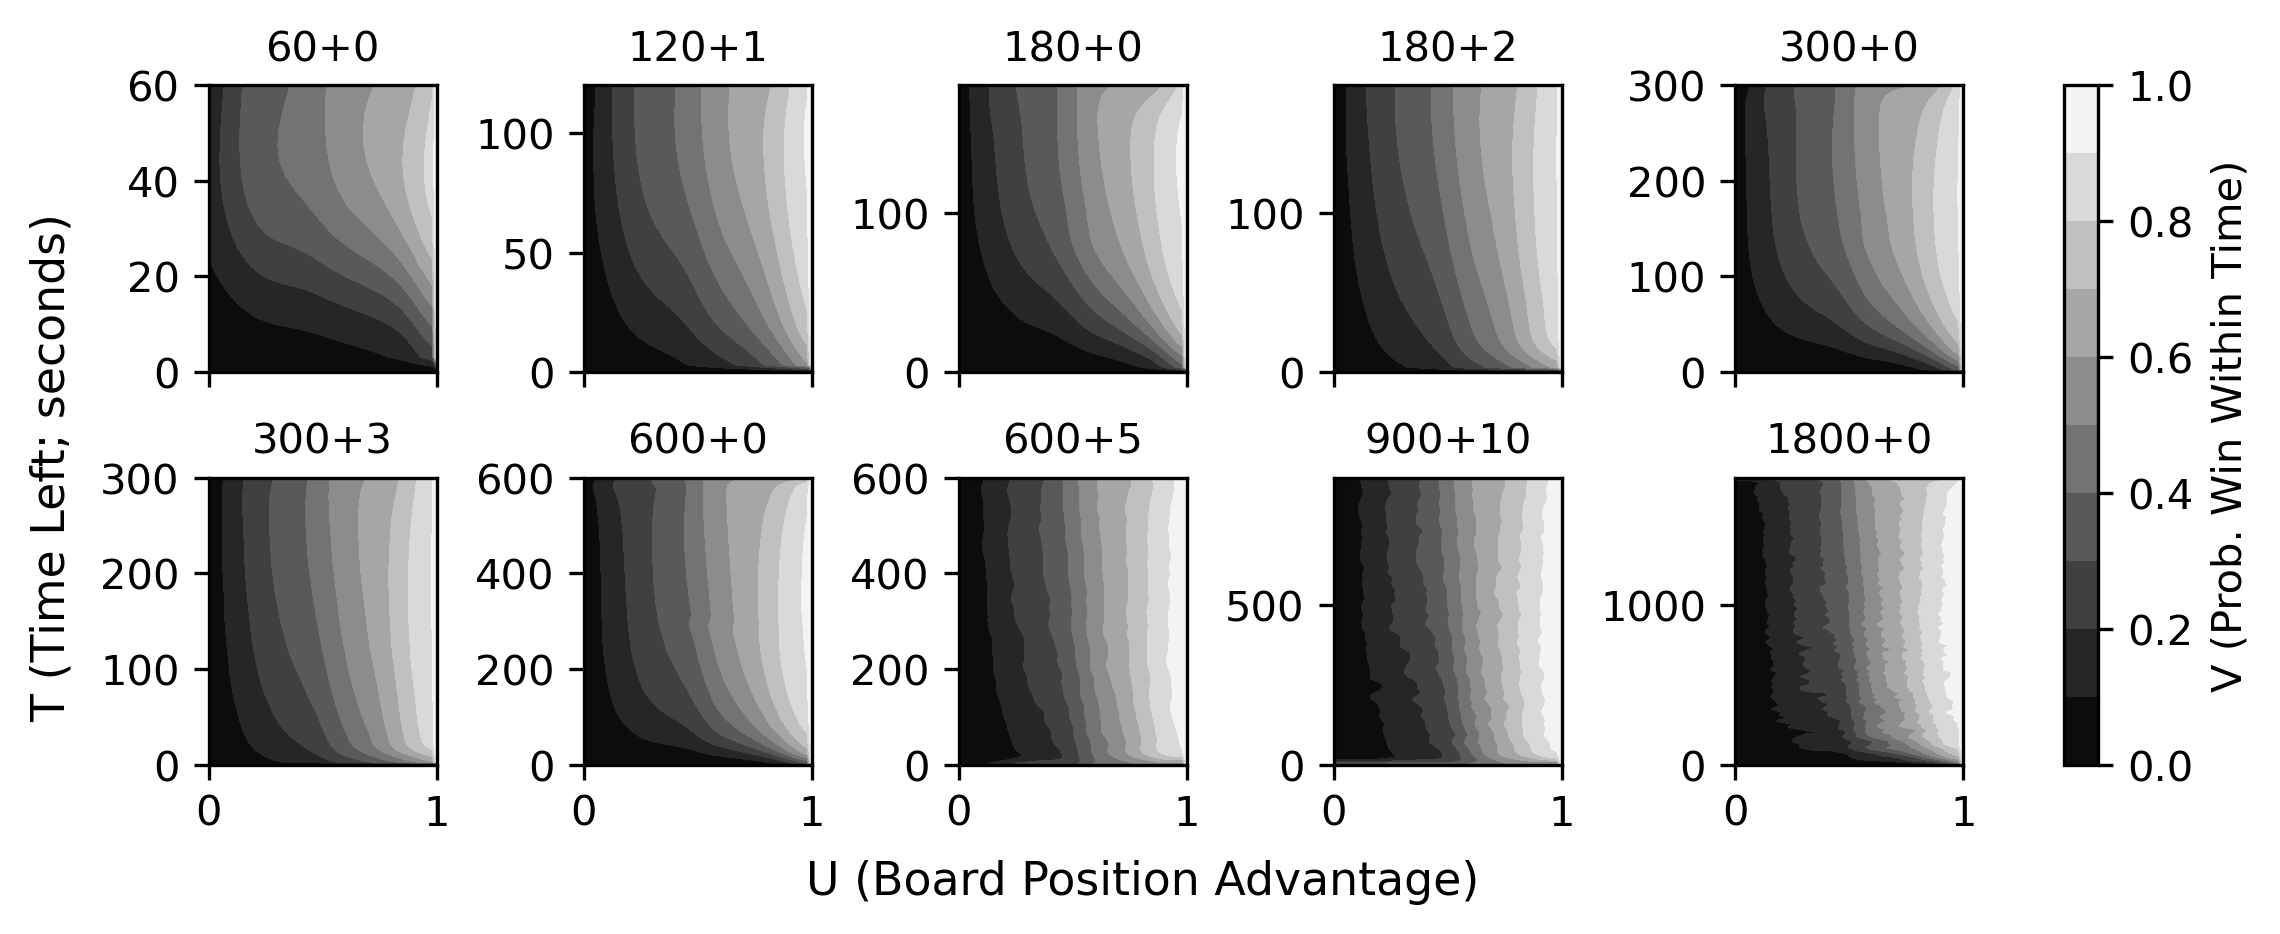

In [6]:
fig,ax = plt.subplots(2,5,constrained_layout=True, sharex=True, figsize=(7.5,3), dpi=300)
for i in range(len(these_tcs)-1):#enumerate([0,1,2,3,4,5,7,8]):#enumerate(range(0,len(these_tcs)-1,2)):  
    
    row = int(np.floor(i / 5))
    col = i % 5
    
    this_tc = these_tcs[i]
    X, Y = np.meshgrid(these_wp[this_tc], these_tl[this_tc])
    cp = ax[row,col].contourf(X,Y,these_Vs[this_tc],levels=10, cmap=cm.gray)
    ax[row,col].set_title(this_tc, fontsize=10)


fig.colorbar(cp,label='V (Prob. Win Within Time)', ax=ax.ravel().tolist())

fig.supylabel('T (Time Left; seconds)',fontsize=11)
fig.supxlabel('U (Board Position Advantage)',fontsize=11)

Make Fig. 7A (180+0 value function)

Text(0.5, 0, 'Board Position Advantage, $U$')

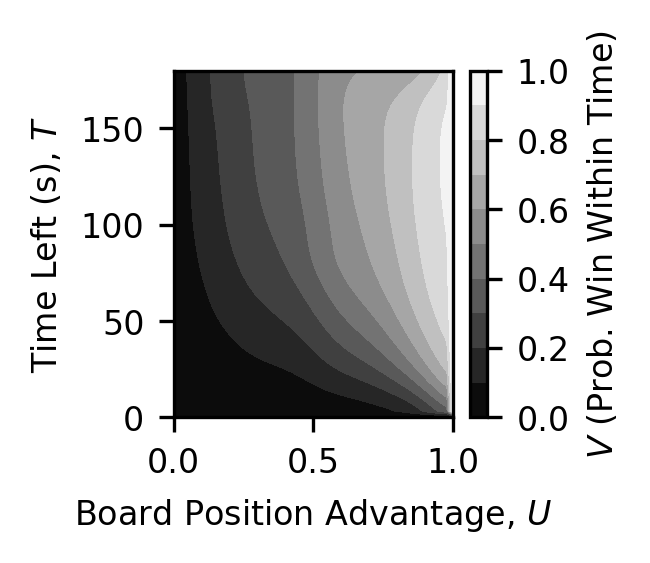

In [7]:
plt.rc('font', size=8)

# plot the V map with the curve drawn on it...
fig,ax = plt.subplots(1,constrained_layout=False, figsize=(6/4,6/4), dpi=300)

tc_idx = 2

this_tc = these_tcs[tc_idx]
X, Y = np.meshgrid(these_wp[this_tc], these_tl[this_tc])
cp = ax.contourf(X,Y,these_Vs[this_tc], levels=10, cmap=cm.gray)

cbar = fig.colorbar(cp, label='$V$ (Prob. Win Within Time)') # Add a colorbar to a plot
cbar.ax.yaxis.label.set_size(8)
ax.set_ylabel('Time Left (s), $T$',fontsize=8)
ax.set_xlabel('Board Position Advantage, $U$',fontsize=8)

Make Fig. 7B (180+0 implied cost function)

Text(0, 0.5, 'Cost of Time Spent, $c$')

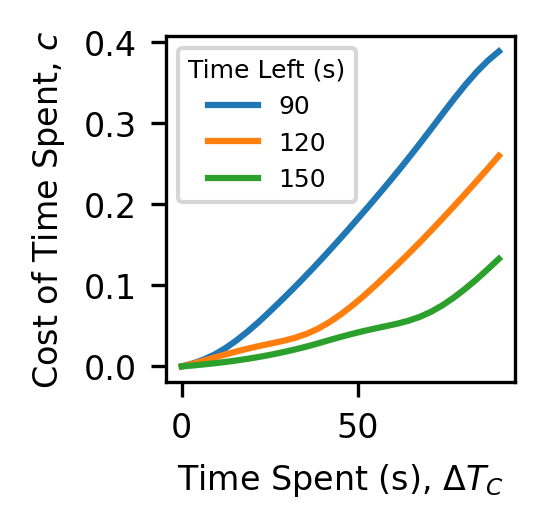

In [8]:
def find_closest_index(arr, x):
    # calculate the difference array
    difference_array = np.absolute(arr-x)

    # find the index of minimum element from the array
    index = difference_array.argmin()
    
    return index

plt.rc('font', size=8)

this_tc = '180+0'
V = these_Vs[this_tc]
TL = these_tl[this_tc]

U_idx = 24

fig,ax = plt.subplots(1, constrained_layout=False, figsize=(6/4,6/4), dpi=300)

for T in [90, 120, 150]:
    
    # How much does V decrease spending 30 seconds waiting?
    plot_delta_T = 90
    T_start = T
    T_end = T - plot_delta_T
    T_start_idx = find_closest_index(TL,T_start)
    T_end_idx = find_closest_index(TL,T_end)

    cost = V[T_start_idx,U_idx] - V[T_start_idx:T_end_idx:-1,U_idx]

    delta_T = np.linspace(0, plot_delta_T, len(cost))

    ax.plot(delta_T, cost, label = T)
    
ax.legend(title='Time Left (s)', fontsize = 6, title_fontsize=6)
ax.set_xlabel('Time Spent (s), $\Delta T_C$', fontsize = 8)
ax.set_ylabel('Cost of Time Spent, $c$', fontsize = 8)

Define optimal policy implied by this value / cost function

In [9]:
# Time threshold is max time (delta_T) willing to wait for benefit (delta_U) such that V(U + delta_U, T - delta_T) >= V(U, T)

def get_time_thresh(T_idx,P_idx,delta_P_idx,V, wp_vals, tl_vals, time_back):
    
    delta_P = wp_vals[delta_P_idx]
    P = wp_vals[P_idx]
    T = tl_vals[T_idx] + time_back # increment
    
    T_idx_eff = find_closest_index(tl_vals,T)
    
    V_rej = V[T_idx_eff,P_idx]

    new_P = np.amin([P + delta_P,1]) # find the index
    new_P_idx = find_closest_index(wp_vals,new_P)

    difference_array = np.absolute(V[:,new_P_idx]-V_rej)
    difference_array[T_idx_eff+1:] = 1e5
    new_T_idx = difference_array.argmin()
    new_T = tl_vals[new_T_idx]

    delta_T = T - new_T
    
    return delta_T

def get_all_max_delta_ts(this_V, this_time_back, wp_vals, tl_vals):

    NU = len(wp_vals)
    NT = len(tl_vals)

    max_delta_Ts = np.zeros((NT, NU, NU))

    for T_idx in range(NT):
        for P_idx in range(NU):
            for delta_P_idx in range(NU):
                
                max_delta_Ts[T_idx,P_idx,delta_P_idx] = get_time_thresh(T_idx,P_idx,delta_P_idx,this_V, wp_vals, tl_vals, this_time_back)

    return max_delta_Ts

Compute max_delta_T (TxUXdelta_U) for every time-control-setting

In [ ]:
all_max_delta_Ts = {}

for tc_idx in range(len(these_tcs)):
    this_tc = these_tcs[tc_idx]
    print(this_tc)
    
    this_time_back = these_time_back[tc_idx]
    wp_vals = these_wp[this_tc]
    tl_vals = these_tl[this_tc]
    this_V = these_Vs[this_tc]

    max_delta_Ts = get_all_max_delta_ts(this_V, this_time_back, wp_vals, tl_vals)
    all_max_delta_Ts[this_tc] = max_delta_Ts
    

60+0
120+1
180+0
180+2
300+0
300+3
600+0
600+5
900+10
1800+0


Make Fig. 7C - example max delta_T for 180+0 condition

In [ ]:
fig,ax = plt.subplots(1,constrained_layout=False,figsize=(6/4,6/4), dpi=300)
plt.rc('font', size=8)

palette = sns.color_palette("rocket", 6)
p_start = 2

# 180+0 condition
tc_idx = 2
this_tc = these_tcs[tc_idx]

# Specify which time-points to use
these_T = (np.array([90,120, 150])/3).astype(int)
time_left = [90, 120, 150]

# use U = .5 (center of value plot)
P_idx = 24

for c_idx, T_idx in enumerate(these_T):
    #these_maxt[]
    good_vals = these_wp[this_tc] <.4#+ these_wp[this_tc][P_idx] < 1


    ax.plot(wp_vals[good_vals], all_max_delta_Ts[this_tc][T_idx,P_idx,good_vals],label=time_left[c_idx])
ax.set_xlim(-.05,.45)
ax.set_ylim(0, these_maxts[tc_idx])

ax.legend(title="Time Left (s):", fontsize=6, title_fontsize = 6)
ax.set_ylabel('Max Time to Wait, $\Delta T_{max}$',fontsize=8)
ax.set_xlabel('Benefit of Computation, $\Delta U_C$',fontsize=8)


Get mean time taken per delta_U and time-control setting for this optimal policy

This first requires a distribution over delta_T (which we estimate from stockfish time taken to get to optimal move)

In [ ]:

depth_time = pd.read_csv(os.path.join(working_folder, "Cost_of_Time_Analysis", "Saved_Quantities", "depth_time.csv"),index_col=0)
p_depth_df = pd.read_csv(os.path.join(working_folder, "Cost_of_Time_Analysis", "Saved_Quantities", "bin_depth_counts.csv"), index_col = 0)
p_depth_counts = p_depth_df.pivot(index='voc_mid', columns='depth', values='nodes').to_numpy() # note that nodes is now the count value
p_depth_counts = p_depth_counts[1:,:]
prop_depth_max = np.sum(p_depth_counts,axis=0)/np.sum(p_depth_counts) 

def get_delta_T(prop_depth_max, depth_time, human_scale, n_delta_T_vals):
    
    dt = depth_time['time']
    dt[0]=0
    
    # first find function between time and prob max...
    x = np.array(human_scale*dt)
    y = prop_depth_max
    f = interp1d(x,y)
    
    # interpolate to get probability over time
    delta_T_vals = np.linspace(x[0],x[-1],n_delta_T_vals)
    P_delta_T = f(delta_T_vals)
    P_delta_T = P_delta_T/np.sum(P_delta_T)
    
    return delta_T_vals,P_delta_T



Getting mean time taken requires getting the time taken per offer (delta_U, U, T) and also the time the implied optimal policy would take per offer

In [ ]:
def get_time_spent_on_offer(this_max_delta_T, delta_T_vals):

    NU = this_max_delta_T.shape[1]
    NT = this_max_delta_T.shape[0]
    N_delta_U = this_max_delta_T.shape[2]
    N_delta_T = len(delta_T_vals)

    Time_Spent_on_Offer = np.zeros((NT, NU, N_delta_T, N_delta_U))

    for T_idx in range(NT):
        for U_idx in range(NU):
            for delta_U_idx in range(N_delta_U):

                max_delta_T = this_max_delta_T[T_idx, U_idx, delta_U_idx]

                these_time_taken = np.copy(delta_T_vals)
                these_time_taken[delta_T_vals >= max_delta_T] = 0 # reject time

                Time_Spent_on_Offer[T_idx, U_idx, :, delta_U_idx] = these_time_taken
    
    return Time_Spent_on_Offer

# get probability distribution over state offers
def get_prob_state_offers(P_TP_g_dU, P_delta_T):

    NU = P_TP_g_dU.shape[1]
    NT = P_TP_g_dU.shape[0]
    N_delta_U = P_TP_g_dU.shape[2]
    N_delta_T = len(P_delta_T)

    P_T_U_dT_g_dU = np.zeros((NT, NU, N_delta_T, N_delta_U))
    print('Delta U: ', end = ' ')
    for delta_U_idx in range(N_delta_U):
        print(delta_U_idx, end= ' ')
        for delta_T_idx in range(N_delta_T):
            #print('Delta U: {}'.format(delta_U_idx))
            tmp_mtx = P_delta_T[delta_T_idx]*P_TP_g_dU[:,:,delta_U_idx]
            P_T_U_dT_g_dU[:,:,delta_T_idx,delta_U_idx] = tmp_mtx
            
    return P_T_U_dT_g_dU


def get_mean_time_taken(this_max_delta_T, this_maxt, this_tc, P_TP_g_dU, N_delta_T, human_scale):

    print("{} Getting Prob over Delta T vals".format(this_tc))
    delta_T_vals,P_delta_T=get_delta_T(prop_depth_max, depth_time, human_scale, N_delta_T)

    print("{} Getting Time Spent on Each Offer".format(this_tc))
    Time_Spent_on_Offer = get_time_spent_on_offer(this_max_delta_T, delta_T_vals)

    print("{} Getting Prob of Each Offer".format(this_tc))
    P_T_U_dT_g_dU = get_prob_state_offers(P_TP_g_dU, P_delta_T)

    N_delta_U = P_TP_g_dU.shape[2]
    mean_time_taken = np.zeros((N_delta_U))
    print("\n {} Computing Mean Time Taken".format(this_tc))
    print('Delta U', end = ' ')
        
    for delta_U_idx in range(N_delta_U):
        print(delta_U_idx, end = ' ')
        mean_time_taken[delta_U_idx] = np.sum(P_T_U_dT_g_dU[:,:,:,delta_U_idx]*Time_Spent_on_Offer[:,:,:,delta_U_idx])
    
    return mean_time_taken
        
# compute mean time taken per time-control setting        
all_mean_time_taken = {}
for tc_idx in [2,3,4, 5]:
    
    N_delta_T = 800
    human_scale = 20000

    this_tc = these_tcs[tc_idx]
    this_max_delta_T = all_max_delta_Ts[this_tc]
    this_maxt = these_maxts[tc_idx]
    
    P_TP_g_dU = these_PTP_wps[this_tc] # T by U by delta_U


    this_mean_time_taken = get_mean_time_taken(this_max_delta_T, this_maxt, this_tc, P_TP_g_dU, N_delta_T, human_scale)
    all_mean_time_taken[this_tc]=this_mean_time_taken
    

Plot Figure 7D

In [ ]:
plt.rc('font', size=8)

fig,ax = plt.subplots(1, figsize=(6/4,6/4),dpi=300)
palette = sns.color_palette(None, 4)

start=0
end= -29
for tc_idx in [2,3,4, 5]:
    this_tc = these_tcs[tc_idx]

    ax.plot(wp_vals[start:end],all_mean_time_taken[this_tc][start:end], color=palette[tc_idx-2])
    ax.text(wp_vals[end-1] + .04, all_mean_time_taken[this_tc][end], this_tc,color=palette[tc_idx-2], fontsize=8)

ax.set_xticks([0, .2, .4])
ax.set_xticklabels([0, .2, .4], fontsize=10)

ax.set_xlim(-.05,.425)

ax.set_xlabel('Benefit of Computation, $\Delta U_{C}$', fontsize=8)
ax.set_ylabel('Move Time (Seconds)',fontsize=8)
